# Battlezone 98 Redux Stats

This is a Work In Progress (WiP)

Battlezone 98 Redux (BZR) is a cool game

In this notebook, all the data from tourneys is compiled and analyzed, with the idea of generating a mathematical model to make a scoring system in the game
___

### Just getting some modules for the program to work, don't mind this

In [1]:
# Modules import
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as stats

### Defining some format parameters and some functions that will be of use later

In [62]:
# Formatting graphs
plt.rcParams['figure.figsize'] = [7, 7]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 11}

plt.rc('font', **font)

# Graphing the values per player as boxenplots, also saving each one to a file
def graph_boxes(df,xvalue='Player'):
    """Graphing the values per player, it will cycle through all the stats"""
    for value in df.columns[3:]:
        print(value)
        #temp_df = df.sort_values([value]).reset_index(drop=True)
        sns.boxenplot(x=xvalue, y=value, data=df)
        plt.xticks(rotation=45)
        #plt.savefig(value+'.png')
        plt.show()
        
def graph_correlation(df,x_value, y_value):
    """Will graph a correlation between the columns given in the 'x_value' and 'y_value'. will also send a distribution plot of the 'disp_value'. All the graphs will also be saved as a .png file"""
    sns.regplot(x_value,y_value,data = df)
    #plt.savefig(y_value+'-vs-'+x_value+'.png')
    plt.show()    

def graph_dispersion(df_column):
    sns.distplot(df_column)
    #plt.savefig(disp_value+'_Distribution'+'.png')
    plt.show()

def drop(df, column, condition,value):
    """Given a DataFrame, the respective column, condition and value related to the condition, it will drop the rows where the condition is True and return another DataFrame With a restored index"""
    # Copy of the original DataFrame
    drops_df = df.copy()
    
    # Iteration through the rows and checking if it must be droped
    #  row will be droped if the 'if' statement is true
    for i, row in drops_df.iterrows():
        if condition == '>':
            if row[column] > value:
                #print(drops_df.loc[i],'\n\n     ^_droped!_^ \n')
                drops_df.drop(i, axis=0, inplace=True)
                
        if condition == '<':
            if row[column] < value:
                #print(drops_df.loc[i],'\n\n     ^_droped!_^ \n')
                drops_df.drop(i, axis=0, inplace=True)
                
        if condition == '==':
            if row[column] == value:
                #print(drops_df.loc[i],'\n\n     ^_droped!_^ \n')
                drops_df.drop(i, axis=0, inplace=True)
                
    return drops_df.reset_index(drop=True)            

___

### Obtaining the data from a .csv file

The data (most of it) from the 2018 and 2019 Battlezone 98 Redux tournaments was compiled from old screenshots and put in a .csv file.

In [3]:
# Getting the data from the file and storing it as a DataFrame
df = pd.read_csv('k-d.csv')
df.head()

,year,Winner,Loser,Kills,Deaths
0,2018,Bazooka,AltoInferno,29,11
1,2018,Bazooka,AltoInferno,27,14
2,2018,Bazooka,BW,20,17
3,2018,Bazooka,DivisionByZero,41,33
4,2018,Bazooka,DivisionByZero,34,8


### Data adjustment

Since the need is having the data per-player instead of matches, the DataFrame has been changed to have a row per-player-per-game with a two new columns, one for a 'Win' condition that will have a value of 1 if the player won (duh) and a K/D ratio column to better analyse the player's stats.

In [4]:
# Manipulation to have a DataFrame, separating the Winners of the losers,
#  Winners will have a value of '1' in the 'Win' column
headers = ['Year', 'Player', 'Win', 'Kills', 'Deaths','KD-ratio']
aux_df= pd.DataFrame(columns=headers)

winner=dict()
loser=dict()
for i in headers:
    winner[i]=''
    loser[i]=''
for i, row in df.iterrows():
    winner['Year'] = row['year']
    winner['Player'] = row['Winner']
    winner['Kills'] = row['Kills']
    winner['Deaths'] = row['Deaths']
    winner['Win'] = 1
    aux_df=aux_df.append(pd.DataFrame(winner,index=[str(i)]))
    
    loser['Year'] = row['year']
    loser['Player'] = row['Loser']
    loser['Kills'] = row['Deaths']
    loser['Deaths'] = row['Kills']
    loser['Win'] = 0
    aux_df=aux_df.append(pd.DataFrame(loser,index=[str(i)]))
df = aux_df.copy()
df = df[headers]
df=df.reset_index(drop=True)

In [5]:
# Data manipulation changes the value of the dtype to object, so it must be restored to int
df[['Win','Kills','Deaths']]=df[['Win','Kills','Deaths']].astype('int')

In [6]:
# Adding a new column, that represents the K/D ratio of the player
df['KD-ratio'] = (df['Kills']/df['Deaths']).astype('float')

In [7]:
# Now with the defined data we now add two dataframes, one for the winners and other for the losers
winners_df = pd.DataFrame(columns=headers)
losers_df = pd.DataFrame(columns=headers)

# Iteration through each row of the DataFrame, 
#  if the value 'Win' equals '1' it will be added to the winners DataFrame,
#  if not it will be added to the losers one pfffft what a loser
for i, row in df.iterrows():
    if row['Win'] == 1:
        winners_df = winners_df.append(row)
    else:
        losers_df = losers_df.append(row)

# Adding rows will change the dtypes to 'object' so they must be turned back to int
winners_df[['Win','Kills','Deaths']]=winners_df[['Win','Kills','Deaths']].astype('int')
losers_df[['Win','Kills','Deaths']]=losers_df[['Win','Kills','Deaths']].astype('int')        

# Reseting the index for both DataFrames
winners_df = winners_df.reset_index(drop=True)
losers_df = losers_df.reset_index(drop=True)

___

## Correlations

Here the correlation between each attribute is calculated to see what aproach would be worth it to check

In [8]:
df.corr()

,Win,Kills,Deaths,KD-ratio
Win,1.000000,0.290092,-0.290092,0.426435
Kills,0.290092,1.000000,0.625357,0.073081
Deaths,-0.290092,0.625357,1.000000,-0.344888
KD-ratio,0.426435,0.073081,-0.344888,1.000000


___

Here we can see there is a positive correlation (thought not so strong) between Kills and Deaths (well, kinda logic), and a smaller correlatoin between the Win condition and K/D ratio (even more logic, you poop), so those values are the most important to check. But, since the Win value is discrete, it wont be used for correlations, the chosen values to check will be KD-Ratio, Kills and Deaths (that are also the importants to check for the later model)

___

## Graphing

Now this is probably why you came here for, the data is presented in different ways:

* **Correlation**: It was chosen to graph the correlations between the values previously named.
* **per-player**: Data is presented in neat enchanced box plots (the type of graphic can be changed at the 'graph_boxes()' function. Here we can have an overall idea of how each player performs, and if there is any big variation between players. This one is mostly to have and idea of the performance each player has

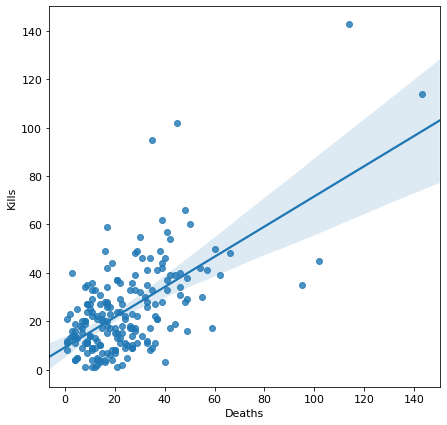

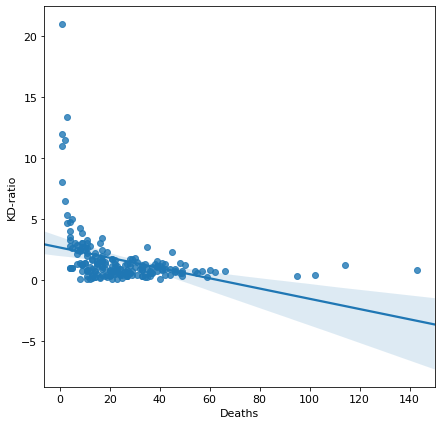

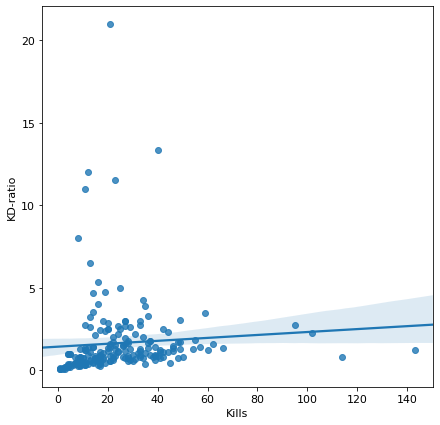

In [63]:
graph_correlation(df,'Deaths','Kills')
graph_correlation(df,'Deaths','KD-ratio')
graph_correlation(df,'Kills','KD-ratio')

It seems that there are K/D ratio values that go far away of the general tendency, let's check the dispersion:

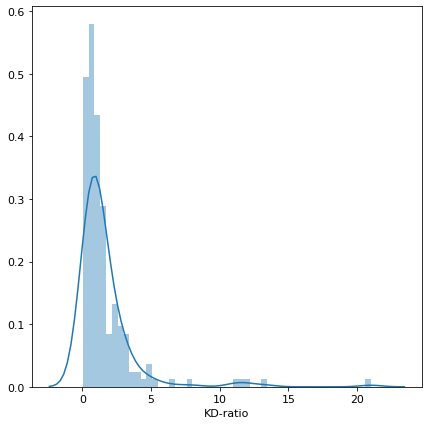

In [64]:
graph_dispersion(df['KD-ratio'])

Clearly the values that go above 5 are far away of the general distribution, this values will considered as "abnormal" and will be droped out of the analysis, then graphed again. There are also only two matches with a Kill-count of over 90, so that data will be considered as abnormal, too.

In [70]:
drops_df = drop(df,'KD-ratio','>',5)
drops_df = drop(drops_df,'Kills','>',90)
drops_df = drop(drops_df,'Deaths','>',90)

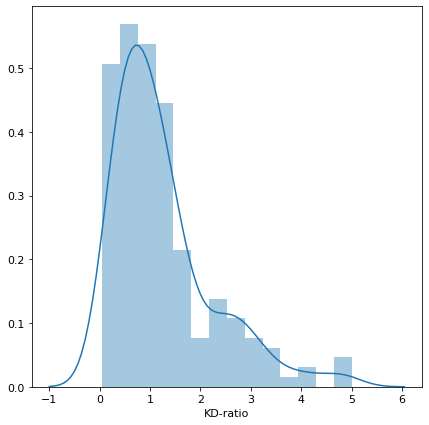

In [71]:
graph_dispersion(drops_df['KD-ratio'])

Let's make it all the above 2, the basis on that is that those values still go away of the normal distribution, and also should be considered abnormals.

Keep in mind that abnormal also means that those values should be taken out of the model to guarantee they'll have a bigger impact in the score model

In [72]:
drops_df=drop(drops_df,'KD-ratio','>',2)

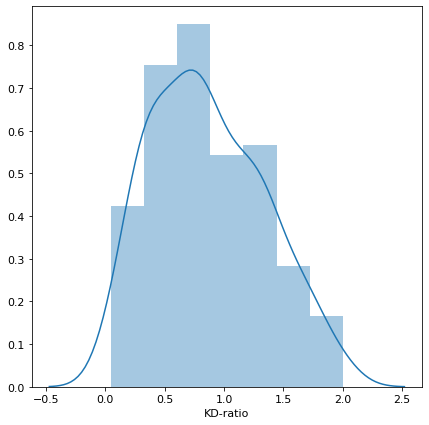

In [73]:
graph_dispersion(drops_df['KD-ratio'])

This one is "better", let's see the correlations

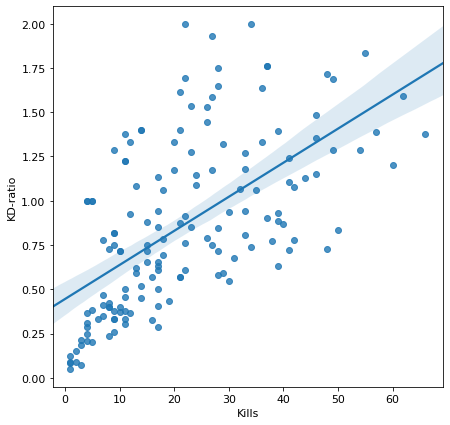

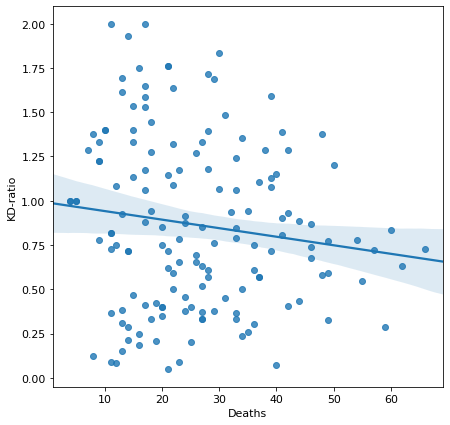

In [74]:
graph_correlation(drops_df, drops_df['Kills'],'KD-ratio')
graph_correlation(drops_df,drops_df['Deaths'],'KD-ratio')

## Partial conclusions

In this case the KD-ratio presents a very light but positive correlation with the kill count, and it's more evenly dispersed respect the death count.

If we consider the previously exposed and that the K/D ratio (KDR) could be considered a "performance" indicator, a candidate for the score system could consist in a function of the type:
___
$Score = K1 + K2 \frac{KDR}{m.Kills} - K3\frac{Deaths}{mean(Deaths)}$
___
That means that, in the pointing system it should be included:
* A constant value due to the win.
* A bonus for the proportional increment of the KDR compared to the expected one.
* A penalty for an amount of deaths higher than the expected.

For now, the considered values of Ks 1, 2 and 3 are:
* K1: 50
* K2: 25
* K3: 10

Further analysis is needed, honestly I don't like the conclusions since the resulting equation doesn't fully fits the analysis made

Incoming:
* Analysis separating winners and losers, to have a corresponding equation for each (but that kinda breaks the system for 3+ players)
* IDK, stuff

___
___
## Overall stats

Now just some cool graphs and tables showing the stats of all players that participated on the 2018 and 2019 BZTs

Kills


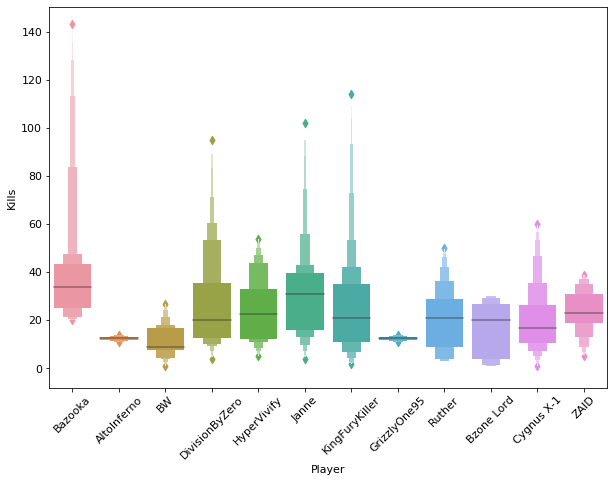

Deaths


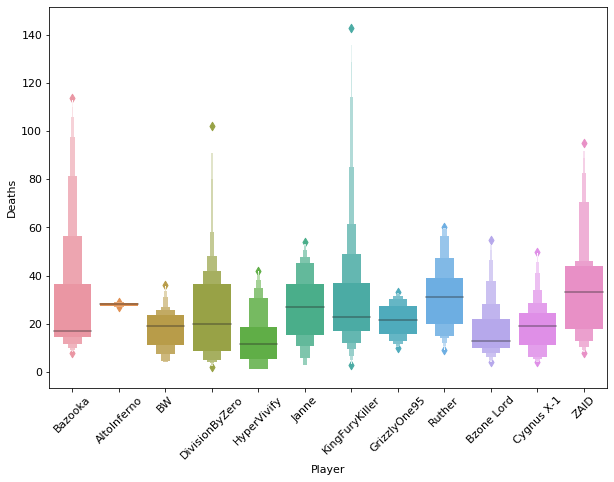

KD-ratio


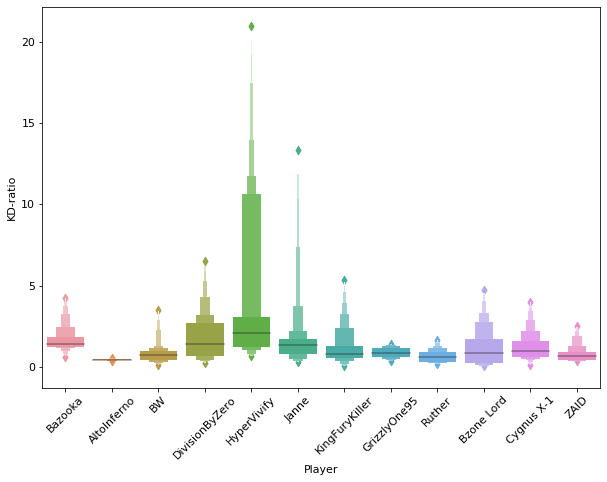

In [84]:
plt.rcParams['figure.figsize'] = [10, 7]
graph_boxes(df)

## Mean Values, first categorized by year and player, then just by player

In [87]:
df.groupby(['Year','Player']).mean()

Win      Kills     Deaths  KD-ratio
Year Player                                                  
2018 AltoInferno     0.000000  12.500000  28.000000  0.448914
     BW              0.200000  11.600000  12.600000  0.926737
     Bazooka         0.909091  42.818182  32.454545  1.719533
     DivisionByZero  0.500000  27.700000  31.100000  1.094124
     GrizzlyOne95    0.500000  12.500000  21.500000  0.866667
     HyperVivify     0.500000  28.500000  20.000000  1.561381
     Janne           0.666667  46.333333  35.333333  1.407071
     KingFuryKiller  0.272727  32.272727  39.181818  1.046469
2019 BW              0.071429  12.000000  19.000000  0.805158
     Bzone Lord      0.461538  16.384615  18.307692  1.306782
     Cygnus X-1      0.300000  20.650000  19.400000  1.269583
     DivisionByZero  0.705882  28.058824  21.470588  2.262975
     HyperVivify     0.833333  24.500000  13.708333  4.080213
     Janne           0.500000  29.100000  25.100000  1.917999
     KingFuryKiller  0.642857  22.785714  24.571429  1.358563
     Ruther          0.380952  20.809524  31.238095  0.669627
     ZAID            0.444444  23.666667  35.777778  0.887827

In [88]:
df.groupby(['Player']).mean()

,Win,Kills,Deaths,KD-ratio
Player,,,,
AltoInferno,0.000000,12.500000,28.000000,0.448914
BW,0.105263,11.894737,17.315789,0.837152
Bazooka,0.909091,42.818182,32.454545,1.719533
Bzone Lord,0.461538,16.384615,18.307692,1.306782
Cygnus X-1,0.300000,20.650000,19.400000,1.269583
DivisionByZero,0.629630,27.925926,25.037037,1.830067
GrizzlyOne95,0.500000,12.500000,21.500000,0.866667
HyperVivify,0.807692,24.807692,14.192308,3.886457
Janne,0.521739,31.347826,26.434783,1.851356


In [89]:
# Exporting all the dataframes as csv to share
df.to_csv('players.csv')
winners_df.to_csv('winners.csv')
losers_df.to_csv('losers.csv')